#Preparing Dataset

In [1]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive/My Drive/TESI

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive/My Drive/TESI


In [2]:
# import modules
import matplotlib.pyplot as plt

In [3]:
# !pip install --upgrade jax

In [4]:
import jax.numpy as jnp
from jax import grad, jit, vmap
from jax import random

In [5]:
from jax import config
config.update("jax_enable_x64", True)

In [6]:
dataset = jnp.load('./data_time.npy', allow_pickle = True)[()]

In [8]:
dataset['points_full'] = dataset['points_full'][0]
dataset['out_fields'] = dataset['out_fields'][0]
del dataset['inp_parameters']

In [9]:
for key in dataset.keys():
  print(key, dataset[key].shape)

times (401,)
points (200, 1)
points_full (401, 200, 1)
out_fields (401, 200, 1)


In [10]:
dataset_train = {}
dataset_test = {}
dataset_train['points'] = dataset['points']
dataset_test['points'] = dataset['points']
for key in ['times', 'points_full', 'out_fields']:
  dataset_train[key] = dataset[key][:201]
  dataset_test[key] = dataset[key][201:]
dataset_train['num_times'] = dataset_train['times'].shape[0]
dataset_train['num_points'] = dataset_train['points'].shape[0]
dataset_test['num_times'] = dataset_test['times'].shape[0]
dataset_test['num_points'] = dataset_test['points'].shape[0]

In [11]:
for key in dataset.keys():
  print(key, 'train: ', dataset_train[key].shape, ' test: ', dataset_test[key].shape)
for key in ['num_times', 'num_points']:
  print(key, 'train: ', dataset_train[key], ' test :', dataset_test[key])

times train:  (201,)  test:  (200,)
points train:  (200, 1)  test:  (200, 1)
points_full train:  (201, 200, 1)  test:  (200, 200, 1)
out_fields train:  (201, 200, 1)  test:  (200, 200, 1)
num_times train:  201  test : 200
num_points train:  200  test : 200


In [12]:
from typing import NamedTuple

class Dataset(NamedTuple):
    num_times: int
    num_points: int
    points_full: jnp.ndarray
    out_fields: jnp.ndarray
    points: jnp.ndarray
    times: jnp.ndarray


dataset_train = Dataset(
    num_times = dataset_train['num_times'],
    num_points = dataset_train['num_points'],
    points_full = dataset_train['points_full'],
    out_fields = dataset_train['out_fields'],
    points = dataset_train['points'],
    times = dataset_train['times']
)

dataset_test = Dataset(
    num_times = dataset_test['num_times'],
    num_points = dataset_test['num_points'],
    points_full = dataset_test['points_full'],
    out_fields = dataset_test['out_fields'],
    points = dataset_test['points'],
    times = dataset_test['times']
)


# Architecture

In [13]:
# A helper function to randomly initialize weights and biases
# for a dense neural network layer
def random_layer_params(m, n, key, scale=1e-1):
  w_key, b_key = random.split(key)
  return scale * random.normal(w_key, (n, m)), scale * random.normal(b_key, (n,))

# Initialize all layers for a fully-connected neural network with sizes "sizes"
def init_network_params(sizes, key):
  keys = random.split(key, len(sizes))
  return [random_layer_params(m, n, k) for m, n, k in zip(sizes[:-1], sizes[1:], keys)]


num_latent_states = 20
dt = 5e-1

layer_sizes_dyn = [num_latent_states,16, 16, 16, num_latent_states]
layer_sizes_rec = [num_latent_states + 1 + 1, 16, 16, 16, 1]
step_size = 5e-2
num_epochs = 200
n_targets = num_latent_states
params_dyn = init_network_params(layer_sizes_dyn, random.key(0))
params_rec = init_network_params(layer_sizes_rec, random.key(1))

In [15]:
@jit
def NNdyn(input, params):
  activations = input
  for w, b in params[:-1]:
    outputs = jnp.dot(w, activations) + b
    activations = jnp.tanh(outputs)
  final_w, final_b = params[-1]
  logits = jnp.dot(final_w, activations) + final_b
  return logits

In [16]:
@jit
def NNrec_sing(input, params):
  activations = input
  for w, b in params[:-1]:
    outputs = jnp.dot(w, activations) + b
    activations = jnp.sin(outputs)
  final_w, final_b = params[-1]
  logits = jnp.dot(final_w, activations) + final_b
  return logits

In [17]:
NNrec = vmap(vmap(NNrec_sing, in_axes = (0, None)), in_axes=(0, None))

In [18]:
def evolve_dynamics(dataset, params):
    # intial condition
    state = jnp.zeros((num_latent_states,), dtype=jnp.float64)
    state_history = jnp.zeros((num_latent_states, dataset.num_times), dtype=jnp.float64)
    state_history = state_history.at[:, 0].set(state)
    dt_ref = 5e-1

    # time integration
    for i in range(dataset.num_times - 1):
        state = state + dt/dt_ref * NNdyn(state, params)
        state_history = state_history.at[:, i + 1].set(state)

    return jnp.transpose(state_history)

def reconstruct_output(dataset, states, params):
    states_expanded = jnp.broadcast_to(jnp.expand_dims(states, axis = 1),
        [dataset.num_times, dataset.num_points, num_latent_states])
    times_expanded = jnp.broadcast_to(jnp.expand_dims(dataset.times, axis = (1,2)),
        [dataset.num_times, dataset.num_points, 1])
    intermediate = jnp.concatenate((states_expanded, times_expanded), axis = 2)
    return NNrec(jnp.concat((dataset.points_full, intermediate), axis = 2), params)

def LDNet(dataset, params):
    states = evolve_dynamics(dataset, params[0])
    return reconstruct_output(dataset, states, params[1])

In [19]:
def MSE(params, dataset):
    out_fields = LDNet(dataset, params)
    error = out_fields - dataset.out_fields
    return jnp.mean(jnp.square(error))

# Auxiliary functions

In [21]:
def get_gradient(params, dataset):
  grad_params = grad(MSE)(params, dataset)
  return grad_params

In [22]:
@jit
def update_params(params, grad_params):
  new_dyn = [(w - step_size * dw, b - step_size * db)
          for (w, b), (dw, db) in zip(params[0], grad_params[0])]
  new_rec = [(w - step_size * dw, b - step_size * db)
          for (w, b), (dw, db) in zip(params[1], grad_params[1])]
  return (new_dyn, new_rec)

# Training

In [23]:
import time

step_size = 1e-1
num_epochs = 300

parameters = (params_dyn, params_rec)
start_time = time.time()
for epoch in range(num_epochs):
  gradients = get_gradient(parameters, dataset_train)
  parameters = update_params(parameters, gradients)
  if epoch % 10 == 0:
    step_size = step_size * 0.9
    epoch_time = time.time() - start_time
    print("Epoch {} in {:0.2f} sec, MSE = {}".format(epoch, epoch_time, MSE(parameters, dataset_train)))

epoch_time = time.time() - start_time
print("Last epoch in {:0.2f} sec, MSE = {}".format(epoch_time, MSE(parameters, dataset_train)))

Epoch 0 in 6.81 sec, MSE = 1.695087479242391
Epoch 10 in 34.45 sec, MSE = 1.686077550552756
Epoch 20 in 61.51 sec, MSE = 1.6850862762335275
Epoch 30 in 88.21 sec, MSE = 1.6793856147377502
Epoch 40 in 115.39 sec, MSE = 1.683425350644091
Epoch 50 in 142.12 sec, MSE = 1.6792983518176163
Epoch 60 in 168.77 sec, MSE = 1.6849796576727556
Epoch 70 in 195.47 sec, MSE = 1.6760001796845594
Epoch 80 in 222.29 sec, MSE = 1.6790747254761231
Epoch 90 in 249.14 sec, MSE = 1.6808044264809212
Epoch 100 in 276.22 sec, MSE = 1.6854557116780466
Epoch 110 in 303.09 sec, MSE = 1.6791324358165207
Epoch 120 in 330.02 sec, MSE = 1.680161780780992
Epoch 130 in 356.85 sec, MSE = 1.6760326536026757
Epoch 140 in 383.66 sec, MSE = 1.68068181874255
Epoch 150 in 410.49 sec, MSE = 1.6775250446091596
Epoch 160 in 437.14 sec, MSE = 1.6803095470600014
Epoch 170 in 463.86 sec, MSE = 1.6790299679122067
Epoch 180 in 490.71 sec, MSE = 1.6799193617424852
Epoch 190 in 517.42 sec, MSE = 1.6702234341041198
Epoch 200 in 544.27 se

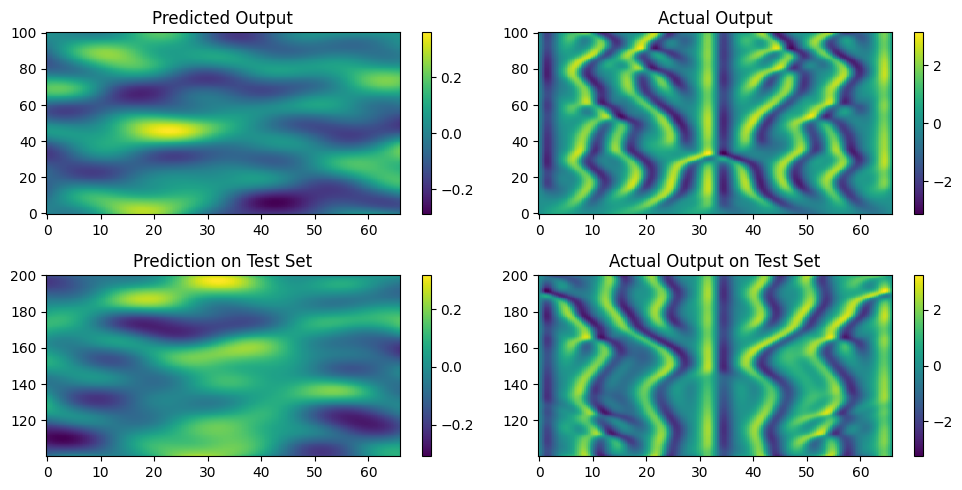

In [24]:
fig, axes = plt.subplots(2, 2, figsize=(10, 5))

t = dataset_train.times.reshape(-1)
x = dataset_train.points.reshape(-1)
X, T = jnp.meshgrid(x,t)

im1 = axes[0][0].pcolormesh(X, T, jnp.squeeze(LDNet(dataset_train, parameters), axis = 2), shading='auto')
axes[0][0].set_title('Predicted Output')
fig.colorbar(im1, ax=axes[0][0])

im2 = axes[0][1].pcolormesh(X, T, jnp.squeeze(dataset_train.out_fields, axis = 2), shading='auto')
axes[0][1].set_title('Actual Output')
fig.colorbar(im2, ax=axes[0][1])

t = dataset_test.times.reshape(-1)
X, T = jnp.meshgrid(x,t)

im3 = axes[1][0].pcolormesh(X, T, jnp.squeeze(LDNet(dataset_test, parameters), axis = 2), shading='auto')
axes[1][0].set_title('Prediction on Test Set')
fig.colorbar(im3, ax=axes[1][0])

im4 = axes[1][1].pcolormesh(X, T, jnp.squeeze(dataset_test.out_fields, axis = 2), shading='auto')
axes[1][1].set_title('Actual Output on Test Set')
fig.colorbar(im4, ax=axes[1][1])

plt.tight_layout()
plt.show()


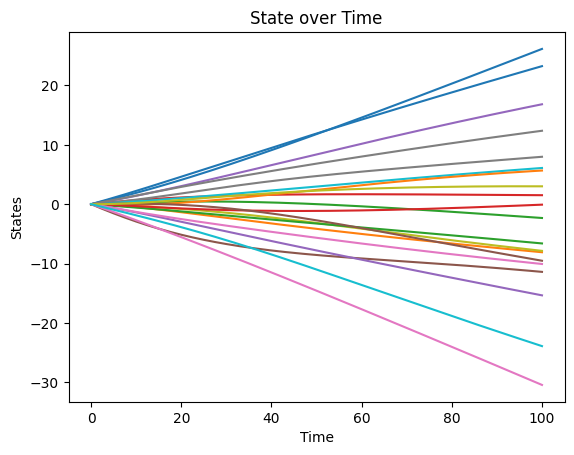

In [25]:
states = evolve_dynamics(dataset_train, parameters[0])
plt.plot(dataset_train.times, states)
plt.xlabel("Time")
plt.ylabel("States")
plt.title("State over Time")
plt.show()